# SMS Spam Collection Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fast')
sns.set_style("ticks")

import string
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.data.path.append('.\\nltk_data')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.dropna(how='any', inplace=True, axis=1)
df.columns = ['type', 'text']

# Binary target column
df['target'] = df['type'].map({'ham':0, 'spam':1})

print(df.shape)
df.head(10)

(5572, 3)


,type,text,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [4]:
df.describe()

,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
# Check for duplicates
print('Number of duplicate entries:', 
df.duplicated().sum())

Number of duplicate entries: 403


Text(0.5, 1.0, 'Target Distribution')

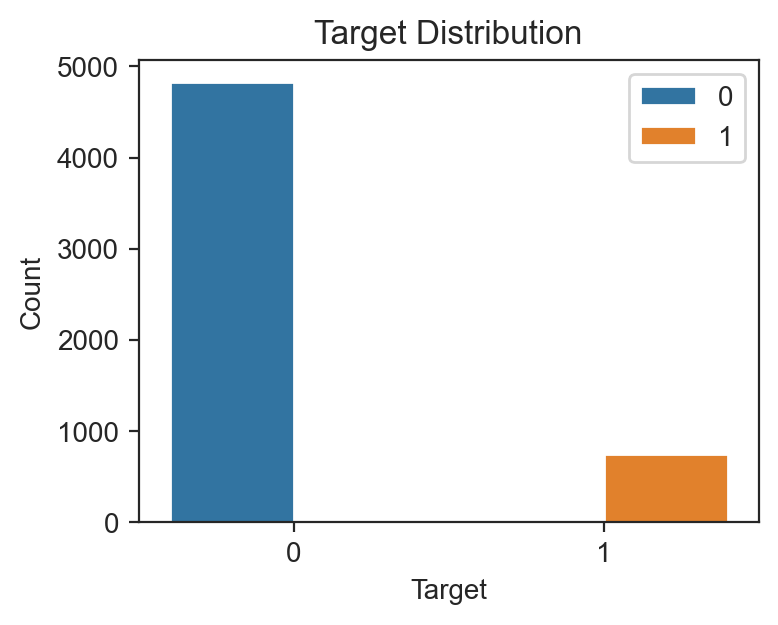

In [6]:
plt.figure(figsize=(4,3), dpi=200)

sns.barplot(x=df['target'].value_counts().index, 
            y=df['target'].value_counts(), 
            hue=df['target'].value_counts().index)

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')

In [7]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(len)

In [8]:
df.head()

,type,text,target,word_count,char_count
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111
1,ham,Ok lar... Joking wif u oni...,0,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155
3,ham,U dun say so early hor... U c already then say...,0,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61


Text(0.5, 0, 'Word Count')

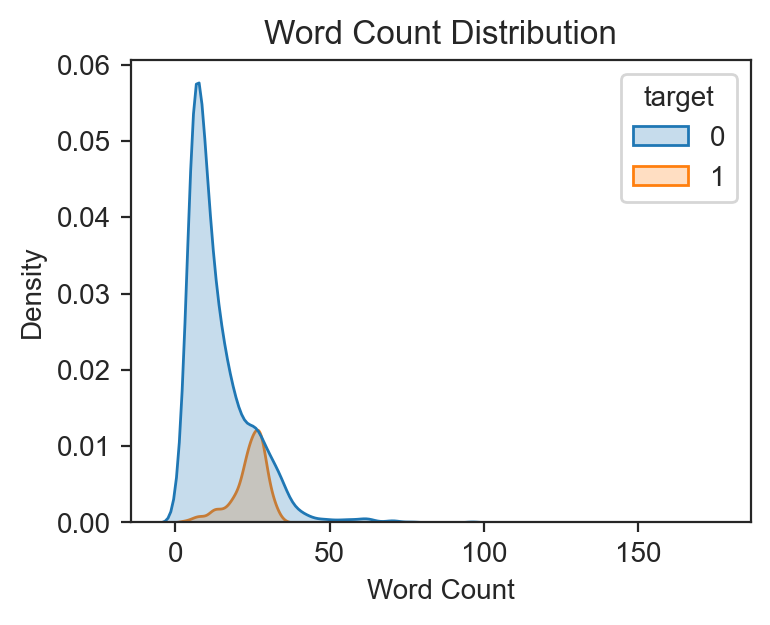

In [9]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=df, x='word_count', 
            hue='target', 
            fill=True)

plt.title('Word Count Distribution')
plt.xlabel('Word Count')

Text(0.5, 0, 'Character Count')

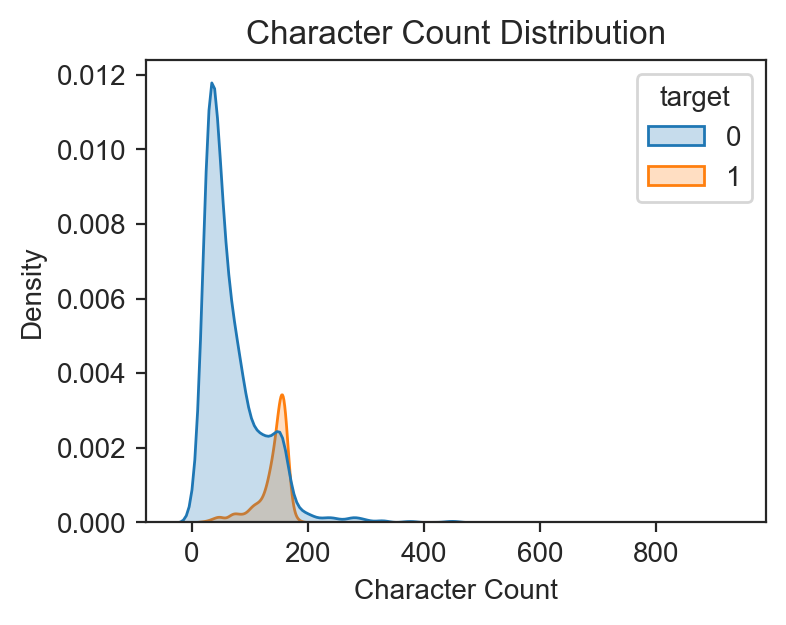

In [10]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=df, x='char_count', 
            hue='target', 
            fill=True)

plt.title('Character Count Distribution')
plt.xlabel('Character Count')

In [11]:
print(df.groupby('target').describe()['char_count'])

         count        mean        std   min    25%    50%    75%    max
target                                                                 
0       4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
1        747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


In [12]:
punctuations = string.punctuation

In [13]:
def remove_punctuations(text):
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    return text

df['cleaned_text'] = df['text'].apply(remove_punctuations)
df.head()

,type,text,target,word_count,char_count,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,0,6,29,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,0,11,49,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,Nah I dont think he goes to usf he lives aroun...


In [14]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_linebreaks(text):
    text = re.sub(r'\n', '', text)
    return text

def clean_text(text):
    text = remove_punctuations(text)
    text = remove_numbers(text)
    text = remove_links(text)
    text = remove_linebreaks(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text).str.lower()

df.head()

,type,text,target,word_count,char_count,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...


In [15]:
word_tokenize(df['cleaned_text'][1])

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

In [16]:
def tokenize(text):
    return nltk.word_tokenize(text)

df['tokenized_text'] = df['cleaned_text'].apply(tokenize)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [17]:
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
more_stopwords = ['u', 'im', 'c', 'ü', 'ur', '4', '2', 'dont', 'doin', 'ure']
stop_words = stop_words + more_stopwords

In [19]:
def remove_stopwords(text):
    text = ' '.join(word for word in text if word not in stop_words).split(' ')
    return text

df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, think, goes, usf, lives, around, though]"


In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text).split(' ')
    return text

df['tokenized_text'] = df['tokenized_text'].apply(lemmatize)

df.head()

,type,text,target,word_count,char_count,cleaned_text,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,go until jurong point crazy available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,6,29,ok lar joking wif u oni,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,free entry in a wkly comp to win fa cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,11,49,u dun say so early hor u c already then say,"[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,nah i dont think he goes to usf he lives aroun...,"[nah, think, go, usf, life, around, though]"


In [21]:
X = df.tokenized_text
y = df.target

X_full_train, X_test, y__full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y__full_train, test_size=0.25, random_state=42)

X_full_train.shape, X_train.shape, X_val.shape, X_test.shape

((4457,), (3342,), (1115,), (1115,))

In [22]:
def dummy(doc):
    return doc

cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)

X_full_train_num = cv.fit_transform(X_full_train)
X_test_num = cv.transform(X_test)

X_train_num = cv.fit_transform(X_train)
X_val_num = cv.transform(X_val)

In [23]:
tfidf = TfidfTransformer()

tfidf.fit_transform(X_train_num)

<3342x5880 sparse matrix of type '<class 'numpy.float64'>'
	with 27181 stored elements in Compressed Sparse Row format>

In [24]:
models = {
    'RF': RandomForestClassifier(),
    'NB': MultinomialNB(),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'SGD': SGDClassifier(),
    'KNN': KNeighborsClassifier()
}

model_scores = {}

In [25]:
def train_eval_model(model, X_train, y_train, X_val):
    
    pipe = Pipeline([
        ('vect', CountVectorizer(tokenizer=dummy, 
                                 preprocessor=dummy)),
        ('tfidf', TfidfTransformer()),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    return y_pred

In [27]:
for name, model in models.items():
    
    y_pred = train_eval_model(model, X_train, y_train, X_val)
    
    scores = {'Accuracy' : f'{accuracy_score(y_val, y_pred):.2f}', 
           'AUC' : f'{roc_auc_score(y_val, y_pred):.2f}', 
           'F1' : f'{f1_score(y_val, y_pred):.2f}'}
    
    model_scores[name] = scores
    
model_scores
    

{'RF': {'Accuracy': '0.97', 'AUC': '0.87', 'F1': '0.84'},
 'NB': {'Accuracy': '0.97', 'AUC': '0.84', 'F1': '0.82'},
 'LR': {'Accuracy': '0.97', 'AUC': '0.84', 'F1': '0.81'},
 'SVM': {'Accuracy': '0.98', 'AUC': '0.89', 'F1': '0.88'},
 'SGD': {'Accuracy': '0.98', 'AUC': '0.92', 'F1': '0.89'},
 'KNN': {'Accuracy': '0.97', 'AUC': '0.87', 'F1': '0.85'}}

In [28]:
y_pred = train_eval_model(SGDClassifier(), 
                          X_full_train, 
                          y__full_train, 
                          X_test)

scores = {'Accuracy' : f'{accuracy_score(y_test, y_pred):.3f}', 
           'AUC' : f'{roc_auc_score(y_test, y_pred):.3f}', 
           'F1' : f'{f1_score(y_test, y_pred):.3f}'}

scores

{'Accuracy': '0.978', 'AUC': '0.934', 'F1': '0.916'}